# CHAPTER 08. 문장(시계열수치)입력 이진분류 모델 레시피

* 모델을 입력하기 위해서 문장을 시계열수치로 인코딩하는 방법과 여러 가지 이진분류모델을 구성해 보고, 학습 결과를 살펴보자.
* 이 모델은 문장 혹은 시계열수치로 양성/음성을 분류하거나 이벤트 발생 유무를 감지하는 문제를 풀 수 있다.

In [40]:
# 사용할 패키지 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, \
                         Conv1D, GlobalMaxPooling1D, MaxPooling1D

%matplotlib inline
import matplotlib.pyplot as plt

## 데이터셋 설명
* IMDB에서 제공하는 영화 리뷰 데이터셋을 이용할 것이다. 이 데이터셋은 훈련셋 25,000개, 시험셋 25,000개의 샘플을 제공한다.
* 라벨은 1과 0으로 좋아요/싫어요로 구성된다.

In [7]:
# 데이터셋 생성하기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

In [3]:
# 훈련셋의 데이터가 어떻게 구성되는지 확인
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


* x_train은 이미 사전에 처리된 데이터를 저장하고 있다.
* 각 단어는 빈도수로 표현된다. (ex. 가장 빈도수가 높은 "the"에 인덱스 1이 대응됨)
* 예를 들어 "To be or not to be" 라는 문장
    * "to" : 5
    * "be" : 8
    * "or" : 21
    * "not" : 3
* 위의 문장을 벡터로 인코딩하면 \[5, 8, 21, 3, 5, 8\] 로 된다.

In [4]:
# 훈련셋 25,000개를 훈련셋 20,000개와 검증셋 5,000개로 분리한다.
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

In [9]:
print(len(x_train[0]))
print(len(x_train[1]))

218
189


모델의 입력으로 사용하려면 데이터를 고정된 길이로 만들어야 하므로 케라스에서 제공되는 전처리 함수인 **sequence의 pad_sequences() 함수를** 사용한다.

In [10]:
x_train = sequence.pad_sequences(x_train, maxlen=200)
x_val = sequence.pad_sequences(x_val, maxlen=200)
x_test = sequence.pad_sequences(x_test, maxlen=200)

* **pad_sequences() 함수 역할**
    * 문장의 길이를 maxlen 인자로 맞춰준다.
    * (num_samples, num_timesteps) 으로 2차원의 numpy 배열로 만들어준다.
        * maxlen을 200으로 지정하면 num_timesteps도 200이 된다.

In [11]:
print(len(x_train[0]))
print(len(x_train[1]))

200
200


<br>

---

<br>

# 모델 준비
## 다층퍼셉트론 모델

<img src="http://tykimos.github.io/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_1m.png">

* 임베딩 레이어로 인코딩한 후 Dense 레이어를 통해 분류하는 다층퍼셉트론 신경망 모델

In [24]:
# 모델 구성하기
model = Sequential()
model.add(Embedding(20000, 128, input_length=200))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

* **임베딩 레이어의 인자**
    * 첫 번째 인자(input_dim): 단어의 종류의 크기를 의미한다. 예시에서는 총 20,000개의 단어 종류가 있다는 것을 의미
    * 두 번째 인자(output_dim): 단어를 인코딩한 후 나오는 벡터 크기이다. 이 값이 128이라면 한 단어의 의미를 128의 공간으로 나타내는 것이다.
    * input_length: 단어의 수, 즉 문자의 길이를 나타낸다.

In [21]:
def learning(model):
    # 모델 학습과정 설정하기
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # 모델 학습시키기
    hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))
    return hist

def review(model, hist):
    # 학습과정 살펴보기
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([-0.2, 1.2])

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylim([-0.2, 1.2])

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuracy')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

    # 모델 평가하기
    loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
    print('## evaluation loss and metrics ##')
    print(loss_and_metrics)

In [25]:
hist = learning(model)

Train on 25000 samples, validate on 5000 samples
Epoch 1/2
25000/25000 [==============================] - 43s 2ms/step - loss: 0.3907 - accuracy: 0.8079 - val_loss: 0.0832 - val_accuracy: 0.9830
Epoch 2/2
25000/25000 [==============================] - 42s 2ms/step - loss: 0.0528 - accuracy: 0.9839 - val_loss: 0.0072 - val_accuracy: 0.9992


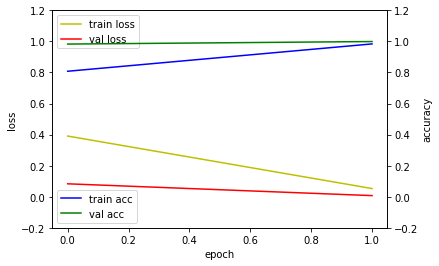

25000/25000 [==============================] - 2s 79us/step
## evaluation loss and metrics ##
[0.4753664931488037, 0.8439199924468994]


In [29]:
review(model, hist)

<br>

---

<br>

# 모델 준비
## 순환 신경망 모델

<img src="http://tykimos.github.io/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_2m.png">

* 문장을 단어들의 시퀀스로 간주하고 순환(LSTM) 레이어의 입력으로 구성한 모델이다.

In [30]:
cycleModel = Sequential()
cycleModel.add(Embedding(20000, 128, input_length=200))
cycleModel.add(Dropout(0.2))
cycleModel.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
cycleModel.add(GlobalMaxPooling1D())
cycleModel.add(Dense(128, activation='relu'))
cycleModel.add(Dropout(0.2))
cycleModel.add(Dense(1, activation='sigmoid'))

In [31]:
cycleHist = learning(cycleModel)

Train on 25000 samples, validate on 5000 samples
Epoch 1/2
25000/25000 [==============================] - 33s 1ms/step - loss: 0.4260 - accuracy: 0.7918 - val_loss: 0.2089 - val_accuracy: 0.9240
Epoch 2/2
25000/25000 [==============================] - 32s 1ms/step - loss: 0.2063 - accuracy: 0.9204 - val_loss: 0.0896 - val_accuracy: 0.9748


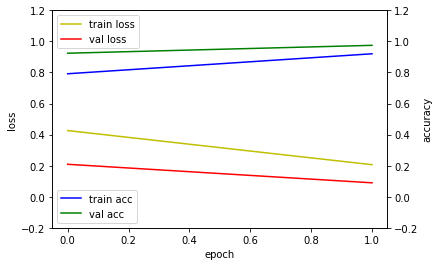

25000/25000 [==============================] - 5s 217us/step
## evaluation loss and metrics ##
[0.2774335992479324, 0.8832399845123291]


In [32]:
review(cycleModel, cycleHist)

<br>

---

<br>

# 모델 준비
## 컨볼루션 신경망 모델

<img src="http://tykimos.github.io/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_3m.png">

* 문장 해석에 컨볼루션(Conv1D) 레이어를 이용한 모델이다.
* 글로벌 맥스풀링(GlobalMaxPooling1D) 레이어는 컨볼루션 레이어가 문장을 훑어가면서 나온 특징벡터들 중 가장 큰 벡터를 골라준다.
* 즉, 문맥을 보면서 주요 특징을 뽑아내고, 그 중 가장 두드러지는 특징을 고르는 것이다.

In [35]:
convModel = Sequential()
convModel.add(Embedding(20000, 128, input_length=200))
convModel.add(Dropout(0.2))
convModel.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
convModel.add(GlobalMaxPooling1D())
convModel.add(Dense(128, activation='relu'))
convModel.add(Dropout(0.2))
convModel.add(Dense(1, activation='sigmoid'))

In [36]:
convHist = learning(convModel)

Train on 25000 samples, validate on 5000 samples
Epoch 1/2
25000/25000 [==============================] - 33s 1ms/step - loss: 0.4271 - accuracy: 0.7868 - val_loss: 0.1987 - val_accuracy: 0.9322
Epoch 2/2
25000/25000 [==============================] - 32s 1ms/step - loss: 0.2037 - accuracy: 0.9216 - val_loss: 0.0767 - val_accuracy: 0.9822


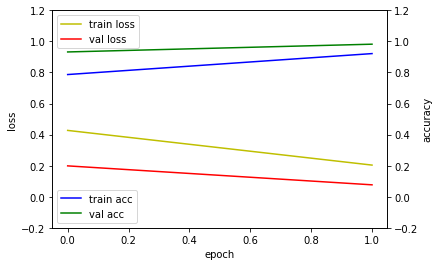

25000/25000 [==============================] - 6s 223us/step
## evaluation loss and metrics ##
[0.2626026689577103, 0.8917999863624573]


In [37]:
review(convModel, convHist)

<br>

---

<br>

# 모델 준비
## 순환 컨볼루션 신경망 모델

<img src="http://tykimos.github.io/warehouse/2017-8-17-Text_Input_Binary_Classification_Model_Recipe_4m.png">

* 컨볼루션 레이어에서 나온 특징벡터들을 맥스풀링(MaxPooling1D)를 통해 1/4로 줄여준 다음 LSTM의 입력으로 넣어주는 모델이다.

In [41]:
cycleConvModel = Sequential()
cycleConvModel.add(Embedding(20000, 128, input_length=200))
cycleConvModel.add(Dropout(0.2))
cycleConvModel.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
cycleConvModel.add(MaxPooling1D(pool_size=4))
cycleConvModel.add(LSTM(128))
cycleConvModel.add(Dense(1, activation='sigmoid'))

In [44]:
cycleConvHist = learning(cycleConvModel)

Train on 25000 samples, validate on 5000 samples
Epoch 1/2
25000/25000 [==============================] - 61s 2ms/step - loss: 0.1065 - accuracy: 0.9639 - val_loss: 0.0495 - val_accuracy: 0.9846
Epoch 2/2
25000/25000 [==============================] - 64s 3ms/step - loss: 0.0510 - accuracy: 0.9850 - val_loss: 0.0283 - val_accuracy: 0.9934


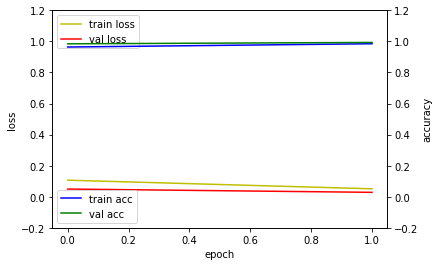

25000/25000 [==============================] - 17s 686us/step
## evaluation loss and metrics ##
[0.5471147270965576, 0.8401200175285339]


In [45]:
review(cycleConvModel, cycleConvHist)

<br>

---

<br>

# 학습결과 비교

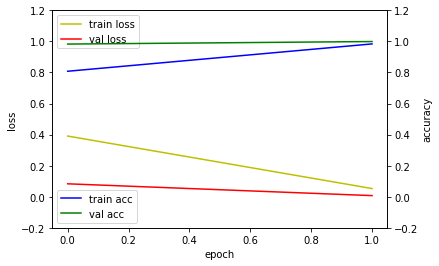

25000/25000 [==============================] - 2s 85us/step
## evaluation loss and metrics ##
[0.4753664931488037, 0.8439199924468994]


In [46]:
review(model, hist)

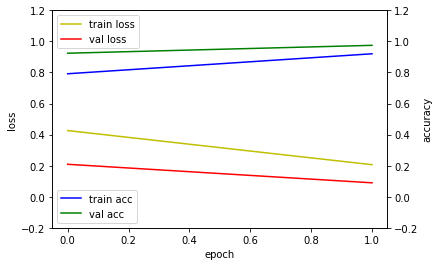

25000/25000 [==============================] - 5s 212us/step
## evaluation loss and metrics ##
[0.2774335992479324, 0.8832399845123291]


In [47]:
review(cycleModel, cycleHist)

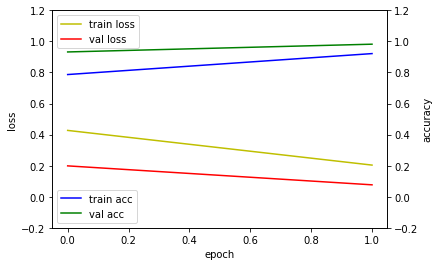

25000/25000 [==============================] - 5s 215us/step
## evaluation loss and metrics ##
[0.2626026689577103, 0.8917999863624573]


In [48]:
review(convModel, convHist)

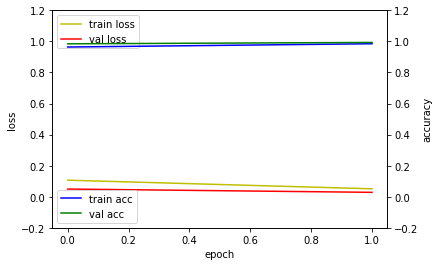

25000/25000 [==============================] - 15s 587us/step
## evaluation loss and metrics ##
[0.5471147270965576, 0.8401200175285339]


In [49]:
review(cycleConvModel, cycleConvHist)